<a href="https://colab.research.google.com/github/ClaudeCoulombe/VIARENA/blob/master/Labos/Lab-Ecorces_Arbres/Id_Ecorces-Res_Conv-Transfert_Ampl-Colab.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Rappel - Fonctionnement d'un carnet web iPython

* Pour exécuter le code contenu dans une cellule d'un carnet iPython, cliquez dans la cellule et faites (⇧↵, shift-enter) 
* Le code d'un carnet iPython s'exécute séquentiellement de haut en bas de la page. Souvent, l'importation d'une bibliothèque Python ou l'initialisation d'une variable est préalable à l'exécution d'une cellule située plus bas. Il est donc recommandé d'exécuter les cellules en séquence. Enfin, méfiez-vous quand vous faites des retours en arrière, cela peut réinitialiser certaines variables.

SVP, déployez toutes les cellules en sélectionnant l'item « Développer les rubriques » de l'onglet « Affichage ».

# Identification d'arbres à partir de leur écorce
## Réseau convolutif, apprentissage par transfert et amplification des données

### Inspiration et droits d'auteur

Ce laboratoire s'inspire de plusieurs oeuvres en logiciels libres qui ont été transformées dont:

<a href="https://www.tensorflow.org/tutorials/images/transfer_learning" target='_blank'>Transfer learning and fine-tuning</a> - site Google / Tutoriels TensorFlow

<a href="https://www.tensorflow.org/tutorials/images/data_augmentation" target='_blank'>Data augmentation</a> - site Google / Tutoriels TensorFlow

##### Copyright (c) 2017, François Chollet  
##### Copyright (c) 2019-2022, The TensorFlow Authors.
##### Copyright (c) 2022, Claude Coulombe

Le contenu de cette page est sous licence <a href="https://creativecommons.org/licenses/by/4.0/deed.fr" target='_blank'>Creative Commons Attribution 4.0 (CC BY 4.0)</a>,<br/>et les exemples de code sont sous <a href="https://www.apache.org/licenses/LICENSE-2.0" target='_blank'>licence Apache 2.0</a>.

#### Données

Les données sur les écorces d'arbres proviennent de <a href="https://data.mendeley.com/research-data/?search=barknet">BarkNet</a>, une banque en données ouvertes sous licence MIT de 23 000 photos d'écorces d'arbres en haute résolution prises avec des téléphones intelligents par une équipe d'étudiants et de chercheurs du <a href="https://www.sbf.ulaval.ca/" target='_blank'>Département des sciences du bois et de la forêt de l'Université Laval</a> à Québec.</p>


# Apprentissage par transfert & amplification des données

## Fixer le hasard pour la reproductibilité

La mise au point de réseaux de neurones implique certains processus aléatoires. Afin de pouvoir reproduire et comparer vos résultats d'expérience, vous fixez temporairement l'état aléatoire grâce à un germe aléatoire unique.

Pendant la mise au point, vous fixez temporairement l'état aléatoire pour la reproductibilité mais vous répétez l'expérience avec différents germes ou états aléatoires et prenez la moyenne des résultats.
<br/>

**Note** : Pour un système en production, vous ravivez simplement l'état  purement aléatoire avec l'instruction `GERME_ALEATOIRE = None`

In [2]:
import os

# Définir un germe aléatoire
GERME_ALEATOIRE = 1

# Définir un état aléatoire pour Python
os.environ['PYTHONHASHSEED'] = str(GERME_ALEATOIRE)

# Définir un état aléatoire pour Python random
import random
random.seed(GERME_ALEATOIRE)

# Définir un état aléatoire pour NumPy
import numpy as np
np.random.seed(GERME_ALEATOIRE)

# Définir un état aléatoire pour TensorFlow
import tensorflow as tf
tf.random.set_seed(GERME_ALEATOIRE)

# Note: Retrait du comportement déterministe
# à cause de keras.layers.RandomContrast(...)
# dont il n'existe pas de version déterministe
# os.environ['TF_DETERMINISTIC_OPS'] = '1'
# os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

print("Germe aléatoire fixé")

Germe aléatoire fixé


## Acquisition des données

Notez qu'en raison, des limites imposées par Colab, nous avons échantillonné 1.5 Go de données sur les 32 Go de données initiales de BarkNet. 

Aussi, nous n'avons pas inclus Acer platanoides (2), Pinus rigida (15) et Populus grandidentata (18) car il n'y a pas suffisamment d'images dans ces catégories pour obtenir des résultats significatifs.

In [3]:

data_ecorces = {
    'SAB': 1,  
#    'ERB': 2,  # Pas assez de spécimens - seulement 1
    'ERR': 3, 
    'ERS': 4, 
    'BOJ': 5, 
    'BOP': 6,
    'HEG': 7,  
    'FRA': 8, 
    'MEL': 9,  
    'OSV': 10, 
    'EPO': 11,
    'EPB': 12,
    'EPN': 13,
    'EPR': 14,
#    'PID': 15, # Pas assez de spécimens - seulement 4
    'PIR': 16, 
    'PIB': 17, 
#    'PEG': 18, # Pas assez de spécimens - seulement 3
    'PET': 19, 
    'CHR': 20,
    'THO': 21, 
    'PRU': 22, 
    'ORA': 23  
}

noms_arbres = {
            1: '\emph{Abies balsamea} - Sapin Baumier - Balsam fir',
            2: '\emph{Acer platanoides} - Érable de Norvège - Norway maple',
            3: '\emph{Acer rubrum} - Érable rouge - Red maple',
            4: '\emph{Acer saccharum} - Érable à sucre - Sugar maple',
            5: '\emph{Betula alleghaniensis} - Bouleau jaune - Yellow birch',
            6: '\emph{Betula papyrifera} - Bouleau à papier - White birch',
            7: '\emph{Fagus grandifolia} - Hêtre à grandes feuilles - American beech',
            8: "\emph{Fraxinus americana} - Frêne d'Amérique - White ash",
            9: '\emph{Larix laricina} - Mélèze - Tamarack',
            10: '\emph{Ostrya virginiana} - Ostryer de Virginie - American hophornbeam',
            11: '\emph{Picea abies} - Épinette de Norvège - Norway spruce',
            12: '\emph{Picea glauca} - Épinette blanche - White spruce',
            13: '\emph{Picea mariana} - Épinette noire - Black spruce',
            14: '\emph{Picea rubens} - Épinette rouge - Red spruce',
            15: '\emph{Pinus rigida} - Pin rigide - Pitch pine',
            16: '\emph{Pinus resinosa} - Pin rouge - Red pine',
            17: '\emph{Pinus strobus} - Pin blanc - Eastern white pine',
            18: '\emph{Populus grandidentata} - Peuplier à grandes dents - Big-tooth aspen',
            19: '\emph{Populus tremuloides} - Peuplier faux tremble - Quaking aspen',
            20: '\emph{Quercus rubra} - Chêne rouge - Northern red oak',
            21: '\emph{Thuja occidentalis} - Thuya occidental - Northern white cedar',
            22: '\emph{Tsuga canadensis} - Pruche du Canada - Eastern Hemlock',
            23: "\emph{Ulmus americana} - Orme d'Amérique - American elm"
        }

dict_no_arbres_ID = {
    '1':'SAB',  
    '2':'ERB',
    '3':'ERR', 
    '4':'ERS', 
    '5':'BOJ', 
    '6':'BOP',
    '7':'HEG',  
    '8':'FRA', 
    '9':'MEL',  
    '10':'OSV', 
    '11':'EPO',
    '12':'EPB',
    '13':'EPN',
    '14':'EPR',
    '15':'PID',
    '16':'PIR', 
    '17':'PIB',
    '18':'PEG',
    '19':'PET', 
    '20':'CHR',
    '21':'THO', 
    '22':'PRU', 
    '23':'ORA'  
}

print("Code exécuté")

Code exécuté


In [4]:
# Dictionnaire Python des URL qui pointent vers des données sur Google Doc
# 

data_zip_urls_dict = {
   "BOJ":"https://drive.google.com/file/d/1d2zxg2pt5S8UJIK-E7IuWfGN0d1kxxMw/view?usp=sharing",
   "BOP":"https://drive.google.com/file/d/12cg6UO4HLnjk5fE_KXtrgdC2s8uGh4Zp/view?usp=sharing",
   "CHR":"https://drive.google.com/file/d/1Nq19-I-Q577KXMTFrkhlJDhMfclh0cWn/view?usp=sharing",
   "EPB":"https://drive.google.com/file/d/1K_Ncw8VEiuDZ_iJDbYToMq-GO5dzKHns/view?usp=sharing",
   "EPN":"https://drive.google.com/file/d/1S309DYmg76SrIA89aVQWXCMwm6CzhN8b/view?usp=sharing",
   "EPO":"https://drive.google.com/file/d/1fTKEcpYgmRg4spUpcH0FAiAnoRgANafL/view?usp=sharing",
   "EPR":"https://drive.google.com/file/d/1qRhtZ8LZjH_45fxetG7swg3ok3znk8CJ/view?usp=sharing",
#   "ERB":"https://drive.google.com/file/d/1ighbGniKAT_GrPm4RtsIAuN1STg9sjR9/view?usp=sharing", # Assez de données?
   "ERR":"https://drive.google.com/file/d/1rEo1thMNJTgFeTzTOfI11_FPSqMgbHSL/view?usp=sharing",
   "ERS":"https://drive.google.com/file/d/1ts-t7bOH9DfKj0q0v35nMgKHgVT0ZjyG/view?usp=sharing",
   "FRA":"https://drive.google.com/file/d/1yLacRGW7JtlFWV5asEXHpAToClL38D64/view?usp=sharing",
   "HEG":"https://drive.google.com/file/d/1zoJKEIrsCD1XxglgPJkEygumev1xRQ3U/view?usp=sharing",
   "MEL":"https://drive.google.com/file/d/1Wdy3DDnWfUysXjcIFFq12UFW7tlTYDT2/view?usp=sharing",
   "ORA":"https://drive.google.com/file/d/19_oYwCAaPfP6vMuqUnAzIQAa39Brxhfi/view?usp=sharing",
   "OSV":"https://drive.google.com/file/d/1VJCCZN1iwBK2Nzh_PHC9xvw63xiLuXXI/view?usp=sharing",
#   "PEG":"https://drive.google.com/file/d/1YUWH4IaTnmcoIAavZq8HyXByJxO7_zBg/view?usp=sharing", # Assez de données?
   "PET":"https://drive.google.com/file/d/13bMkvr_1mRz1TuOcX8-c-LfTSIsNKrve/view?usp=sharing",
   "PIB":"https://drive.google.com/file/d/17J9g1xm6-ji52k2pgJr7mUrJdS1ASSqP/view?usp=sharing",
#   "PID":"https://drive.google.com/file/d/12xswrf4pDmTAcYZDAY9D-0HniLjGJCxp/view?usp=sharing", # Assez de données?
   "PIR":"https://drive.google.com/file/d/1qny4meuoT-HYZ_KTyPQbQnzLhebkgkfU/view?usp=sharing",
   "PRU":"https://drive.google.com/file/d/1xQWHQvIbwRRBoi2F27q22_drUeM8m3S8/view?usp=sharing",
   "SAB":"https://drive.google.com/file/d/1ol2mlYAz5bMfQkwqcnxhCOg4avftYtRe/view?usp=sharing",
   "THO":"https://drive.google.com/file/d/1_mI0saGpfxb4wnhElCzxg0WU4OiFHkfP/view?usp=sharing",
  
}
data_zip_urls_dict

{'BOJ': 'https://drive.google.com/file/d/1d2zxg2pt5S8UJIK-E7IuWfGN0d1kxxMw/view?usp=sharing',
 'BOP': 'https://drive.google.com/file/d/12cg6UO4HLnjk5fE_KXtrgdC2s8uGh4Zp/view?usp=sharing',
 'CHR': 'https://drive.google.com/file/d/1Nq19-I-Q577KXMTFrkhlJDhMfclh0cWn/view?usp=sharing',
 'EPB': 'https://drive.google.com/file/d/1K_Ncw8VEiuDZ_iJDbYToMq-GO5dzKHns/view?usp=sharing',
 'EPN': 'https://drive.google.com/file/d/1S309DYmg76SrIA89aVQWXCMwm6CzhN8b/view?usp=sharing',
 'EPO': 'https://drive.google.com/file/d/1fTKEcpYgmRg4spUpcH0FAiAnoRgANafL/view?usp=sharing',
 'EPR': 'https://drive.google.com/file/d/1qRhtZ8LZjH_45fxetG7swg3ok3znk8CJ/view?usp=sharing',
 'ERR': 'https://drive.google.com/file/d/1rEo1thMNJTgFeTzTOfI11_FPSqMgbHSL/view?usp=sharing',
 'ERS': 'https://drive.google.com/file/d/1ts-t7bOH9DfKj0q0v35nMgKHgVT0ZjyG/view?usp=sharing',
 'FRA': 'https://drive.google.com/file/d/1yLacRGW7JtlFWV5asEXHpAToClL38D64/view?usp=sharing',
 'HEG': 'https://drive.google.com/file/d/1zoJKEIrsCD1XxglgPJ

In [5]:
# Création des répertoires de données
# Nous allons créer un répertoire de base `data` et des répertoires pour les données 
# d'entrainement, de validation et de test pour chaque étiquette cible

try:
    os.mkdir("/content/data/")
except OSError:
    pass
try:
    os.mkdir("/content/lab_ecorces/")
except OSError:
    pass
try:
    os.mkdir("/content/modeles/")
except OSError:
  pass


In [6]:
# Demande d'autorisation pour télécharger les données sur Google Drive 
# Référence: https://colab.research.google.com/notebooks/io.ipynb

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os
import shutil
import zipfile

In [7]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [8]:
nombre_classes = 0
for arbre_id in data_zip_urls_dict.keys():
    url = data_zip_urls_dict[arbre_id]
    id_fichier = url.split('/')[5]
    fichier = drive.CreateFile({'id':id_fichier})
    nom_fichier = arbre_id + ".zip"
    # télécharger le fichier nom_fichier
    fichier.GetContentFile("/content/data/" + nom_fichier)
    print("Fichier " + nom_fichier + " téléchargé")
    zip_ref = zipfile.ZipFile("/content/data/" + nom_fichier, 'r')
    zip_ref.extractall("/content/data")
    zip_ref.close()
    print("Fichier " + nom_fichier + " décompressé")
    try:
        os.remove("/content/data/"+nom_fichier)
        print("Fichier " + nom_fichier + " effacé")
    except:
        print("?")
    nombre_classes += 1
shutil.rmtree('/content/data/__MACOSX')
print("nombre_classes:",nombre_classes)

Fichier BOJ.zip téléchargé
Fichier BOJ.zip décompressé
Fichier BOJ.zip effacé
Fichier BOP.zip téléchargé
Fichier BOP.zip décompressé
Fichier BOP.zip effacé
Fichier CHR.zip téléchargé
Fichier CHR.zip décompressé
Fichier CHR.zip effacé
Fichier EPB.zip téléchargé
Fichier EPB.zip décompressé
Fichier EPB.zip effacé
Fichier EPN.zip téléchargé
Fichier EPN.zip décompressé
Fichier EPN.zip effacé
Fichier EPO.zip téléchargé
Fichier EPO.zip décompressé
Fichier EPO.zip effacé
Fichier EPR.zip téléchargé
Fichier EPR.zip décompressé
Fichier EPR.zip effacé
Fichier ERR.zip téléchargé
Fichier ERR.zip décompressé
Fichier ERR.zip effacé
Fichier ERS.zip téléchargé
Fichier ERS.zip décompressé
Fichier ERS.zip effacé
Fichier FRA.zip téléchargé
Fichier FRA.zip décompressé
Fichier FRA.zip effacé
Fichier HEG.zip téléchargé
Fichier HEG.zip décompressé
Fichier HEG.zip effacé
Fichier MEL.zip téléchargé
Fichier MEL.zip décompressé
Fichier MEL.zip effacé
Fichier ORA.zip téléchargé
Fichier ORA.zip décompressé
Fichier O

### Répartition des données

In [9]:
# Installation des bibliothèques Python `split-folders` et `tqdm`
!pip3 install split-folders tqdm

In [10]:
# Répartition des données d'entraînement, de validation et de tests
import splitfolders
import pathlib

#### répertoire des données en entrée et des données une fois réparties
repertoire_entree = "/content/data"
repertoire_donnees_reparties = "/content/lab_ecorces"
# => train, val, test

nombre_images = len(list(pathlib.Path(repertoire_entree).glob('*/*.jpg')))
print("Nombre total d'images:",nombre_images)

splitfolders.ratio(repertoire_entree, output=repertoire_donnees_reparties, seed=42, ratio = (0.80, 0.15, 0.05))

print("\nRépartition des données terminée!")

Nombre total d'images: 3981


Copying files: 3981 files [00:05, 698.32 files/s]


Répartition des données terminée!


### Visualisation d'un échantillon des données

In [11]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

pic_index = 4

REPERTOIRE_ENTRAINEMENT = "/content/lab_ecorces/train/"

for arbre_id in data_ecorces.keys():
    try:
        dir_path = os.path.join(TRAINING_DIR,arbre_id+os.sep)
        liste_fichiers = os.listdir(os.path.join(TRAINING_DIR,arbre_id+os.sep))
        next_two_pics = [os.path.join(dir_path, fname) for fname in liste_fichiers[0:pic_index]]
        fig = plt.figure(figsize=(12,4))
        print("_"*90)
        print(arbre_id,noms_arbres[data_ecorces[arbre_id]].split('-')[1])
        for i, img_path in enumerate(next_two_pics):
            print(img_path)
            img = mpimg.imread(img_path)
            plt.subplot(1,pic_index,i+1)
            plt.imshow(img)
            plt.axis('Off')
        plt.show()
    except:
        continue

### Création de flux de lots de données

Chargeons ces images en mémoire en créant des `tf.data.dataset` à l'aide de l'utilitaire `tf.keras.utils.image_dataset_from_directory`. 

tf.data.Dataset prend en charge l'écriture de chaîne de traitement d'entrée de données efficaces. L'itération se produit dans un flux continu, de sorte que l'ensemble de données complet n'a pas besoin de tenir dans la mémoire.

In [12]:
import os
import numpy as np
import keras
print("Version de Keras:",keras.__version__)
import tensorflow as tf
print("Version de TensorFlow :",tf.__version__)

Version de Keras: 2.8.0
Version de TensorFlow : 2.8.0


In [13]:
REPERTOIRE_ENTRAINEMENT = "/content/lab_ecorces/train/"
REPERTOIRE_VALIDATION = "/content/lab_ecorces/val"
REPERTOIRE_TEST = "/content/lab_ecorces/test/"

TAILLE_LOT = 32
HAUTEUR_IMAGE = 150
LARGEUR_IMAGE = 150
TAILLE_IMAGE = (HAUTEUR_IMAGE, LARGEUR_IMAGE)
NOMBRE_CANAUX = 3

donnees_entrainement = tf.keras.utils.image_dataset_from_directory(REPERTOIRE_ENTRAINEMENT,
                                                                   batch_size=TAILLE_LOT,
                                                                   image_size=TAILLE_IMAGE)

Found 3175 files belonging to 20 classes.


In [14]:
print("Type Python de donnees_entrainement):",type(donnees_entrainement))
flux_images, flux_etiquettes = next(iter(donnees_entrainement))
print("Dimensions du flux d'images:",flux_images.shape)
print("Nombre d'images):",len(flux_images))
print("Dimensions du flux d'étiquettes:",flux_etiquettes.shape)
print("Nombre d'étiquettes):",len(flux_etiquettes))

Type Python de donnees_entrainement): <class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>
Dimensions du flux d'images: (32, 150, 150, 3)
Nombre d'images): 32
Dimensions du flux d'étiquettes: (32,)
Nombre d'étiquettes): 32


In [15]:
liste_noms_classes = donnees_entrainement.class_names
print(liste_noms_classes)
print(len(liste_noms_classes))

['BOJ', 'BOP', 'CHR', 'EPB', 'EPN', 'EPO', 'EPR', 'ERR', 'ERS', 'FRA', 'HEG', 'MEL', 'ORA', 'OSV', 'PET', 'PIB', 'PIR', 'PRU', 'SAB', 'THO']
20


In [16]:
donnees_validation = tf.keras.utils.image_dataset_from_directory(REPERTOIRE_VALIDATION,
                                                                 batch_size=TAILLE_LOT,
                                                                 image_size=TAILLE_IMAGE)

Found 588 files belonging to 20 classes.


In [17]:
donnees_test = tf.keras.utils.image_dataset_from_directory(REPERTOIRE_TEST,
                                                           batch_size=TAILLE_LOT,
                                                           image_size=TAILLE_IMAGE)

Found 218 files belonging to 20 classes.


In [18]:
print("Nombre de lots de données d'entraînement: %d" % tf.data.experimental.cardinality(donnees_entrainement))
print("Nombre de lots de données de validation: %d" % tf.data.experimental.cardinality(donnees_validation))
print('Nombre de lots de données de test: %d' % tf.data.experimental.cardinality(donnees_test))

Nombre de lots de données d'entraînement: 100
Nombre de lots de données de validation: 19
Nombre de lots de données de test: 7


## Prétraitement des données

### Amplification des données

In [19]:
couches_amplification = tf.keras.Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomFlip("vertical"),
    keras.layers.RandomRotation(0.1),
    keras.layers.RandomZoom(0.3),
    keras.layers.RandomContrast(0.3),
])

### Normalisation des données

In [20]:
couches_normalisation = keras.Sequential([
    keras.layers.Resizing(HAUTEUR_IMAGE,LARGEUR_IMAGE),
    keras.layers.Rescaling(1./255)
])

In [21]:
AUTOTUNE = tf.data.AUTOTUNE

def pretraitement(jeu_donnees, melanger=False, amplifier=False):

    if melanger:
        jeu_donnees = jeu_donnees.shuffle(1000)
        
    # Amplifier seulement les données d'entraînement
    if amplifier:
        jeu_donnees = jeu_donnees.map(lambda x, y: (couches_amplification(x,training=True), y),
                                      num_parallel_calls=AUTOTUNE
                                     )
        
    # Normaliser les jeux de données
    jeu_donnees = jeu_donnees.map(lambda x, y: (couches_normalisation(x), y),
                                  num_parallel_calls=AUTOTUNE
                                 )
    
    # Utiliser des tampons de préextraction sur tous les jeux de données
    return jeu_donnees.prefetch(buffer_size=AUTOTUNE)

print("Fonction de prétraitement prête!")

Fonction de prétraitement prête!


#### Visualisation d'un échantillon de données amplifiées

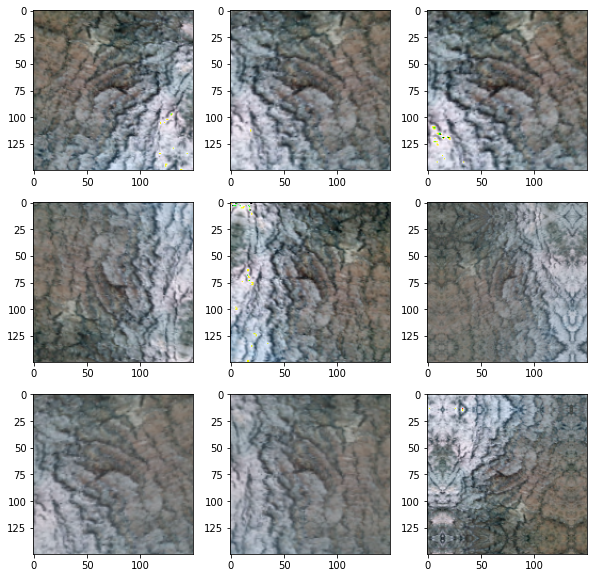

In [22]:
fig = plt.figure(figsize=(10, 10))
for images, _ in donnees_entrainement.take(1):
    fig.clear()
    for i in range(9):
        images_augmentees = couches_amplification(images)
        plt.subplot(3, 3, i + 1)
        plt.imshow(images_augmentees[0].numpy().astype("uint8"))
        # plt.imshow(augmented_images[0], cmap="gray")

#### Normalisation des données d'entraînement

In [23]:
print("Type Python de donnees_entrainement):",type(donnees_entrainement))
donnees_entrainement_normalisees = pretraitement(donnees_entrainement,
                                                 melanger=True,
                                                 amplifier=True)
print("Type Python donnees_entrainement_normalisees):",type(donnees_entrainement_normalisees))
lot_images, lot_etiquettes = next(iter(donnees_entrainement_normalisees))
premiere_image = lot_images[0]
# Notez que les valeurs des pixels sont maintenant dans l'intervalle `[0,1]`
print(np.min(premiere_image), np.max(premiere_image))

Type Python de donnees_entrainement): <class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>
Type Python donnees_entrainement_normalisees): <class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>
0.1490697 0.7890408


In [24]:
images, etiquettes = next(iter(donnees_entrainement_normalisees))
print("Dimensions flux d'images:",images.shape)
print("Nombre d'images:",len(images))
print("Dimensions flux d'étiquette:",etiquettes.shape)
print("Nombre d'étiquettes:",len(images))

Dimensions flux d'images: (32, 150, 150, 3)
Nombre d'images: 32
Dimensions flux d'étiquette: (32,)
Nombre d'étiquettes: 32


#### Normalisation des données de validation

In [25]:
print("Type Python de donnees_validation):",type(donnees_validation))
donnees_validation_normalisees = pretraitement(donnees_validation,
                                               melanger=False,
                                               amplifier=False)
print("Type Python donnees_validation_normalisees):",type(donnees_validation_normalisees))
lot_images, lot_etiquettes = next(iter(donnees_validation_normalisees))
premiere_image = lot_images[0]
# Notez que les valeurs des pixels sont maintenant dans l'intervalle `[0,1]`
print(np.min(premiere_image), np.max(premiere_image))

Type Python de donnees_validation): <class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>
Type Python donnees_validation_normalisees): <class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>
0.003772646 1.0


In [26]:
images, etiquettes = next(iter(donnees_validation_normalisees))
print("Dimensions flux d'images:",images.shape)
print("Nombre d'images:",len(images))
print("Dimensions flux d'étiquette:",etiquettes.shape)
print("Nombre d'étiquettes:",len(images))

Dimensions flux d'images: (32, 150, 150, 3)
Nombre d'images: 32
Dimensions flux d'étiquette: (32,)
Nombre d'étiquettes: 32


#### Normalisation des données de test

In [27]:
print("Type Python de donnees_test):",type(donnees_test))
AUTOTUNE = tf.data.AUTOTUNE
donnees_test = donnees_test.cache().prefetch(buffer_size=AUTOTUNE)
print("Type Python de donnees_test):",type(donnees_test))
donnees_test_normalisees = donnees_test.map(lambda x, y: (couches_normalisation(x), y))
print("Type Python de donnees_test_normalisees:",type(donnees_test_normalisees))
lot_images, lot_etiquettes = next(iter(donnees_test_normalisees))
premiere_image = lot_images[0]
# Notez que les valeurs des pixels sont maintenant dans l'intervalle `[0,1]`
print(np.min(premiere_image), np.max(premiere_image))

Type Python de donnees_test): <class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>
Type Python de donnees_test): <class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>
Type Python de donnees_test_normalisees: <class 'tensorflow.python.data.ops.dataset_ops.MapDataset'>
0.050091308 1.0


In [28]:
images, etiquettes = next(iter(donnees_test_normalisees))
print("Dimensions flux d'images:",images.shape)
print("Nombre d'images:",len(images))
print("Dimensions flux d'étiquette:",etiquettes.shape)
print("Nombre d'étiquettes:",len(images))

Dimensions flux d'images: (32, 150, 150, 3)
Nombre d'images: 32
Dimensions flux d'étiquette: (32,)
Nombre d'étiquettes: 32


## Création d'un modèle d'apprentissage par transfert

### Importation d'un modèle inception pré-entraîné sur ImageNet

In [29]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2022-03-08 07:06:57--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 142.250.99.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  70.0MB/s    in 1.2s    

2022-03-08 07:06:58 (70.0 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [30]:
from tensorflow.keras import layers
from tensorflow.keras import Model

from tensorflow.keras.applications.inception_v3 import InceptionV3

# Charger les paramètres ou poids du modèle InceptionV3 pré-entraîné sur ImageNet
modele_preentraine = InceptionV3(weights='imagenet',
                                 input_shape = (HAUTEUR_IMAGE,LARGEUR_IMAGE,NOMBRE_CANAUX),
                                 include_top = False)


87924736/87910968 [==============================] - 2s 0us/step


In [31]:
# modele_preentraine.summary()

### Module d'extraction d'attributs visuels

#### Détermination de la couche de sortie et de la couche où débute le peaufinage

In [32]:
modele_preentraine.trainable = True

# Combien de couches se trouvent dans le modèle pré-entraîné
nbr_couches_modele_preentraine = len(modele_preentraine.layers)
print("Nombre de couches dans le modèle pré-entraîné d'origine: ", nbr_couches_modele_preentraine)

# Comment obtenir l'index de la couche à partir de l'identifiant de la couche 
# https://www.thetopsites.net/article/50151157.shtml
liste_noms_de_couche = [couche.name for couche in modele_preentraine.layers]
nom_derniere_couche = liste_noms_de_couche[-1]
print("Nom de la dernière couche du modèle pré-entraîné complet:",nom_derniere_couche)
index_derniere_couche = liste_noms_de_couche.index(nom_derniere_couche)
print("Index de la dernière couche du modèle pré-entraîné complet:",index_derniere_couche)

# Choix d'une nouvelle couche de sortie par essai / erreur
# cette étape assez laborieuse a été réalisée pour vous simplifier la tâche
nom_derniere_couche = 'mixed5'
print("Choix empirique de la dernière couche du modèle pré-entraîné:",nom_derniere_couche)
index_derniere_couche = liste_noms_de_couche.index(nom_derniere_couche)
print("Index de la dernière couche du modèle pré-entraîné choisie empiriquement:",index_derniere_couche)

# Choix de la dernière couche non-entraînable ou dernière couche « gelée » du modèle pré-entraîné
nom_derniere_couche_gelee = 'mixed3'
print("Choix empirique de la dernière couche non-entraînable:",nom_derniere_couche_gelee)
index_derniere_couche_gelee = liste_noms_de_couche.index(nom_derniere_couche_gelee)
print("Index de la dernière couche non-entraînable:",index_derniere_couche_gelee)
# Paufiner l'entraînement à partir de la dernière couche non-entraînable
debut_paufinage = index_derniere_couche_gelee
print("Nombre de couches gelées (non entraînables) dans le modèle préentraîné: ", debut_paufinage )
# Geler tous les couches avant la couche `debut_paufinage`
for couche in modele_preentraine.layers[:debut_paufinage]:
    couche.trainable =  False

print("Nombre de couches entraînables dans le modèle préentraîné: ", index_derniere_couche-debut_paufinage)
derniere_couche = modele_preentraine.get_layer(nom_derniere_couche)
print('Dimensions de la dernière couche: ', derniere_couche.output_shape)
sortie_derniere_couche = derniere_couche.output


Nombre de couches dans le modèle pré-entraîné d'origine:  311
Nom de la dernière couche du modèle pré-entraîné complet: mixed10
Index de la dernière couche du modèle pré-entraîné complet: 310
Choix empirique de la dernière couche du modèle pré-entraîné: mixed5
Index de la dernière couche du modèle pré-entraîné choisie empiriquement: 164
Choix empirique de la dernière couche non-entraînable: mixed3
Index de la dernière couche non-entraînable: 100
Nombre de couches gelées (non entraînables) dans le modèle préentraîné:  100
Nombre de couches entraînables dans le modèle préentraîné:  64
Dimensions de la dernière couche:  (None, 7, 7, 768)


### Ajout d'un module de classification
#### Perceptron multicouche

In [33]:
# Ajouter une couche de régularisation par extinction de neurones (dropout)
sorties = layers.Dropout(0.1)(sortie_derniere_couche)
# Aplatir la couche de sortie en un vecteur (i.e. une dimension)
sorties = layers.Flatten()(sorties)
# Ajouter une couche entièrement connectée avec 1024 neurones cachés et l'activation ReLU
sorties = layers.Dense(1024, activation='relu')(sorties)
# Ajouter une couche de régularisation par extinction (dropout)
sorties = layers.Dropout(0.2)(sorties)      
# Ajouter une couche de sortie entièrement connectée de 20 neurones 
# avec l'activation softmax (exponentielle normalisée)
# *** IMPORTANT *** 20 classes => 20 neurones de sortie
sorties = layers.Dense(nombre_classes, activation='softmax')(sorties)           
modele_de_transfert = Model(modele_preentraine.input, sorties) 
print("Nombre de couches dans le modèle d'apprentissage par transfert: ", len(modele_de_transfert.layers))


Nombre de couches dans le modèle d'apprentissage par transfert:  170


In [34]:
# transfer_model.summary()
print("Nombre de paramètres entraînables dans le modèle de transfert: ",len(modele_de_transfert.trainable_variables))

Nombre de paramètres entraînables dans le modèle de transfert:  44


## Compilation du modèle

In [35]:
from tensorflow.keras.optimizers import RMSprop

# D'après la documentation, tf.keras.utils.image_dataset_from_directory, encodera par défaut 
# un ensemble d'étiquettes de classes sous forme d'entiers allant de 1 au nombre de classes.
# Dans ce cas, le modèle doit être compilé avec une fonction d'erreur 'sparse_categorical_crossentropy'

modele_de_transfert.compile(optimizer = RMSprop(learning_rate=0.0001),
                            loss = 'sparse_categorical_crossentropy',
                            metrics = ['accuracy'])

print("Modèle compilé!")

Modèle compilé!


## Entraînement du modèle

In [36]:
nombre_iterations_de_base = 10
nombre_iterations_peaufinage = 30
nombre_total_iterations =  nombre_iterations_de_base + nombre_iterations_peaufinage

# Les fonctions de rappels sont passées au modèle via l'argument callbacks de .fit(...), 
# qui prend une liste de fonctions de rappels. 
liste_fonctions_rappels = [
    # Mémoriser le meilleur modèle
    keras.callbacks.ModelCheckpoint(
        filepath="IdEcorces_ResConv_TransAmpl.keras",
        save_best_only=True,
        # Surveiller l'erreur de validation
        monitor="val_loss"),
    # Arrêter l'entraînement quand son amélioration stagne
    keras.callbacks.EarlyStopping(
        # Surveiller l'exactitude de validation
        monitor='val_accuracy',
        # Arrêter l'entraînement quand l'exactitude stagne
        # depuis plus de 10 itérations (i.e., 11 itérations)
        patience=10,
        verbose=2),
    # Ajuster le taux taux d'apprentissage ou gain du gradient
    keras.callbacks.ReduceLROnPlateau(
        # Surveiller l'erreur de validation
        monitor='val_loss',
        # Diviser le taux d'apprentissage par 2 
        # lorsque la fonction de rappel est déclenchée
        factor=0.5,
        # La fonction de rappel est déclenchée quand l'erreur de validation 
        # a cessé de s'améliorer depuis 3 itérations
        patience=3,
        verbose=2) 
]

traces_entrainement = modele_de_transfert.fit(donnees_entrainement_normalisees,
                                              validation_data = donnees_validation_normalisees,
                                              epochs = nombre_total_iterations,
                                              callbacks=liste_fonctions_rappels,
                                              verbose = 2)

Epoch 1/40
100/100 - 53s - loss: 2.1641 - accuracy: 0.3846 - val_loss: 1.3409 - val_accuracy: 0.5391 - lr: 1.0000e-04 - 53s/epoch - 531ms/step
Epoch 2/40
100/100 - 38s - loss: 1.2506 - accuracy: 0.5978 - val_loss: 1.0032 - val_accuracy: 0.6769 - lr: 1.0000e-04 - 38s/epoch - 384ms/step
Epoch 3/40
100/100 - 40s - loss: 1.0310 - accuracy: 0.6617 - val_loss: 0.9686 - val_accuracy: 0.7160 - lr: 1.0000e-04 - 40s/epoch - 397ms/step
Epoch 4/40
100/100 - 39s - loss: 0.8777 - accuracy: 0.7244 - val_loss: 0.8491 - val_accuracy: 0.7398 - lr: 1.0000e-04 - 39s/epoch - 395ms/step
Epoch 5/40
100/100 - 38s - loss: 0.7735 - accuracy: 0.7550 - val_loss: 1.0883 - val_accuracy: 0.6854 - lr: 1.0000e-04 - 38s/epoch - 376ms/step
Epoch 6/40
100/100 - 38s - loss: 0.7206 - accuracy: 0.7638 - val_loss: 0.9558 - val_accuracy: 0.7296 - lr: 1.0000e-04 - 38s/epoch - 381ms/step
Epoch 7/40
100/100 - 39s - loss: 0.6182 - accuracy: 0.7950 - val_loss: 0.8069 - val_accuracy: 0.7585 - lr: 1.0000e-04 - 39s/epoch - 393ms/step

### Affichage des courbes d'entraînement

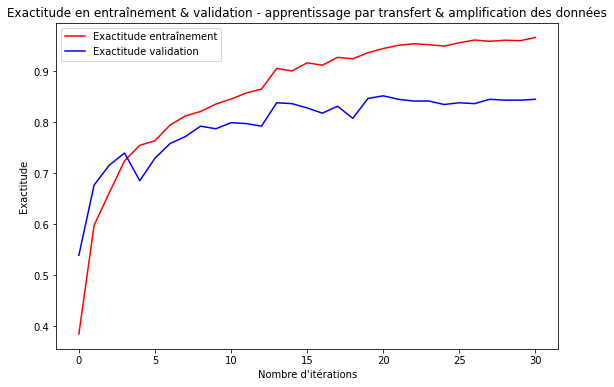

In [37]:
# Dernière couche 'mixed5', dernière couche gelée 'mixed3'
# 40 itérations & amplification
# exactitude sur les données de test: de 80 à 85%
import matplotlib.pyplot as plt
exactitude_entrainement = traces_entrainement.history['accuracy']
exactitude_validation = traces_entrainement.history['val_accuracy']
erreur_entrainement = traces_entrainement.history['loss']
erreur_validation = traces_entrainement.history['val_loss']
nombre_iterations = range(len(exactitude_entrainement))
nombre_dor = 1.618
hauteur = 6
longueur = int(nombre_dor * hauteur)
plt.figure(figsize=(longueur,hauteur))
plt.plot(nombre_iterations, exactitude_entrainement, 'r', label='Exactitude entraînement')
plt.plot(nombre_iterations, exactitude_validation, 'b', label='Exactitude validation')
plt.title("Exactitude en entraînement & validation - apprentissage par transfert & amplification des données")
plt.legend(loc=0)
plt.xlabel("Nombre d'itérations")
plt.ylabel("Exactitude")
plt.show()


### Évaluation du modèle avec des données de test

In [38]:
erreur_test, exactitude_test = modele_de_transfert.evaluate(donnees_test_normalisees)
print("Exactitude sur les données de test: %0.2f" % exactitude_test)

7/7 [==============================] - 2s 46ms/step - loss: 0.9190 - accuracy: 0.8119
Exactitude sur les données de test: 0.81


### Résultats

Les résultats obtenus se situent dans une fourchette de 82 à 85%, ce qui est un bon départ considérant l'emploi de 1.5 Go de données (21 fois moins de données) que le jeu de données original de 32 Go. 

Une façon d'augmenter la quantité de données consisterait à diviser les images originales en tuiles plus petites. 

### Analyse des résultats sur les données de test

#### Prédiction sur les données de test

Extraction des étiquettes prédites

In [39]:
predictions = modele_de_transfert.predict(donnees_test_normalisees)
index_predictions = np.argmax(predictions, axis=1)
liste_etiquettes_predites = [(etiquette+1) for etiquette in index_predictions]
print(liste_etiquettes_predites)

[9, 3, 12, 4, 5, 9, 4, 3, 12, 17, 12, 8, 15, 9, 1, 15, 6, 3, 16, 9, 6, 3, 6, 10, 4, 19, 3, 3, 9, 12, 16, 10, 3, 12, 14, 6, 14, 12, 9, 12, 8, 8, 14, 16, 2, 19, 6, 6, 8, 9, 17, 12, 15, 8, 16, 20, 8, 4, 6, 6, 8, 4, 16, 15, 5, 3, 3, 9, 7, 14, 17, 6, 3, 6, 15, 10, 4, 9, 3, 16, 4, 19, 8, 2, 3, 12, 6, 5, 3, 1, 7, 9, 14, 16, 18, 16, 15, 9, 18, 19, 12, 9, 9, 19, 1, 15, 6, 5, 9, 12, 16, 12, 3, 9, 16, 5, 3, 15, 10, 5, 17, 3, 16, 3, 5, 10, 18, 1, 17, 7, 4, 3, 20, 2, 7, 6, 1, 4, 12, 9, 5, 11, 6, 6, 20, 2, 20, 14, 3, 8, 20, 10, 2, 3, 19, 4, 15, 12, 14, 10, 20, 1, 15, 9, 20, 19, 16, 3, 16, 18, 9, 12, 3, 1, 20, 10, 9, 11, 10, 3, 9, 19, 10, 18, 2, 5, 18, 3, 11, 3, 9, 10, 12, 15, 3, 11, 3, 4, 5, 3, 1, 2, 8, 16, 19, 3, 8, 5, 11, 11, 17, 4, 7, 7, 1, 10, 6, 19]


Extraction des vraies étiquettes

In [40]:
index_vraies_etiquettes = list(np.concatenate([etiquette for image, etiquette in donnees_test_normalisees], axis=0))
liste_vraies_etiquettes = [(etiquette+1) for etiquette in index_vraies_etiquettes]
print(liste_vraies_etiquettes)

[9, 9, 12, 15, 5, 9, 4, 3, 12, 17, 12, 8, 15, 9, 1, 15, 1, 3, 16, 8, 6, 3, 6, 10, 4, 19, 3, 3, 8, 12, 16, 10, 3, 12, 14, 6, 14, 12, 9, 12, 8, 13, 14, 16, 2, 19, 6, 6, 11, 8, 17, 12, 15, 8, 7, 20, 8, 4, 6, 6, 13, 4, 16, 15, 5, 18, 3, 9, 19, 14, 17, 17, 3, 6, 15, 10, 6, 13, 3, 16, 4, 19, 8, 2, 9, 12, 6, 5, 3, 1, 18, 9, 14, 16, 18, 13, 15, 9, 18, 19, 12, 9, 15, 19, 1, 15, 6, 5, 8, 12, 16, 12, 3, 9, 13, 5, 3, 15, 10, 5, 17, 3, 3, 3, 5, 10, 18, 2, 17, 7, 19, 3, 20, 2, 7, 6, 1, 4, 7, 8, 20, 11, 6, 6, 20, 2, 20, 14, 9, 11, 20, 10, 1, 18, 11, 4, 8, 12, 14, 10, 20, 1, 15, 10, 20, 5, 9, 3, 16, 18, 8, 12, 3, 1, 20, 10, 9, 11, 10, 3, 9, 4, 10, 18, 2, 5, 18, 3, 11, 15, 9, 10, 12, 15, 3, 11, 3, 4, 5, 9, 1, 2, 8, 16, 19, 3, 8, 12, 11, 11, 17, 4, 7, 7, 1, 10, 6, 19]


In [41]:
from sklearn import metrics
exactitude_test = metrics.accuracy_score(liste_vraies_etiquettes, liste_etiquettes_predites)
print("Exactitude:   %0.2f" % exactitude_test)

Exactitude:   0.81


#### Affichage d'une matrice de confusion

Matrice de confusion non normalisée


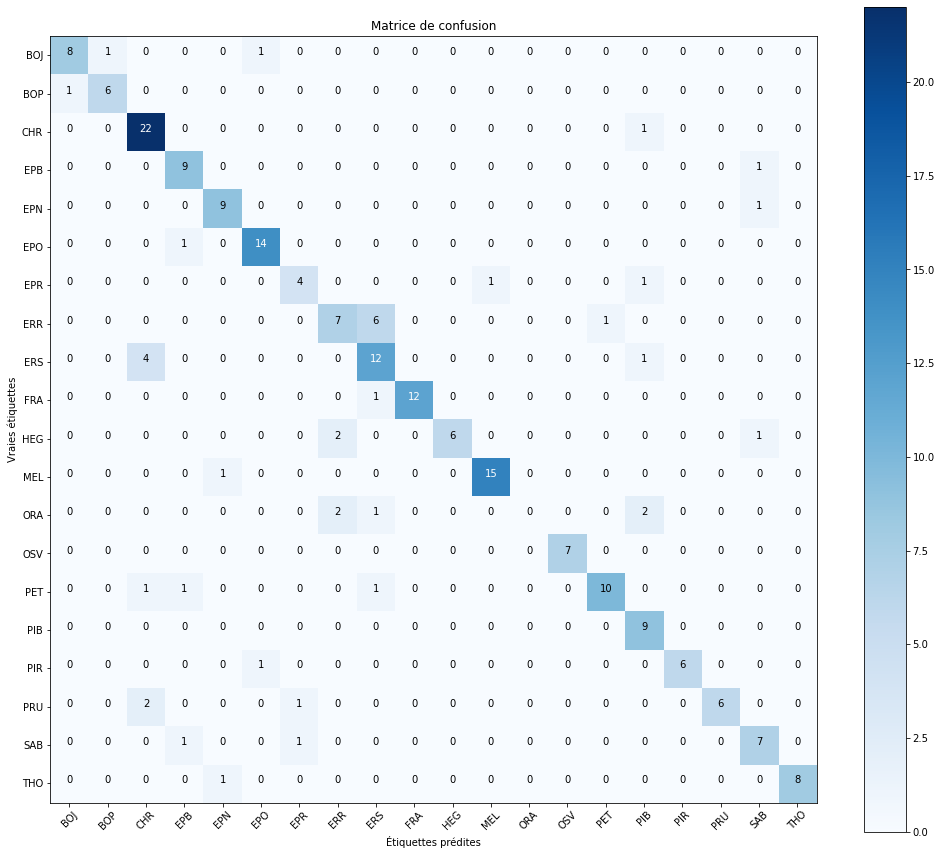

In [42]:
# https://stackoverflow.com/questions/65618137/confusion-matrix-for-multiple-classes-in-python

import itertools

def afficher_matrice_de_confusion(matrice_confusion_brute, classes,
                          normalisation=False,
                          titre='Matrice de confusion',
                          carte_des_couleurs=plt.cm.Blues):
    plt.figure(figsize=(14,12))
    plt.imshow(matrice_confusion_brute, interpolation='nearest', cmap=carte_des_couleurs)
    plt.title(titre)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalisation:
        matrice_confusion_brute = matrice_confusion_brute.astype('float') / matrice_confusion_brute.sum(axis=1)[:, np.newaxis]
        print("Matrice de confusion normalisée")
    else:
        print('Matrice de confusion non normalisée')

    seuil = matrice_confusion_brute.max() / 2.
    for i, j in itertools.product(range(matrice_confusion_brute.shape[0]), range(matrice_confusion_brute.shape[1])):
        plt.text(j, i, matrice_confusion_brute[i, j],
                 horizontalalignment="center",
                 color="white" if matrice_confusion_brute[i, j] > seuil else "black")

    plt.tight_layout()
    plt.ylabel('Vraies étiquettes')
    plt.xlabel('Étiquettes prédites')

matrice_confusion_brute = metrics.confusion_matrix(liste_vraies_etiquettes, liste_etiquettes_predites)
afficher_matrice_de_confusion(matrice_confusion_brute, classes=liste_noms_classes)

#### Rapport de classification

In [43]:
from sklearn.metrics import classification_report

print(classification_report(liste_vraies_etiquettes, liste_etiquettes_predites, target_names=liste_noms_classes))

              precision    recall  f1-score   support

         BOJ       0.89      0.80      0.84        10
         BOP       0.86      0.86      0.86         7
         CHR       0.76      0.96      0.85        23
         EPB       0.75      0.90      0.82        10
         EPN       0.82      0.90      0.86        10
         EPO       0.88      0.93      0.90        15
         EPR       0.67      0.67      0.67         6
         ERR       0.64      0.50      0.56        14
         ERS       0.57      0.71      0.63        17
         FRA       1.00      0.92      0.96        13
         HEG       1.00      0.67      0.80         9
         MEL       0.94      0.94      0.94        16
         ORA       0.00      0.00      0.00         5
         OSV       1.00      1.00      1.00         7
         PET       0.91      0.77      0.83        13
         PIB       0.64      1.00      0.78         9
         PIR       1.00      0.86      0.92         7
         PRU       1.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Sauvegarde du modèle entraîné

In [44]:
import os
import time

chemin_sauvegarde = "/content/modeles/"

# Ajouter une estampille temporelle (timestamp)
estampille_temporelle = str(int(time.time()))
chemin_modele_sauvegarde = os.path.join(chemin_sauvegarde, estampille_temporelle)
modele_de_transfert.save(chemin_modele_sauvegarde)

INFO:tensorflow:Assets written to: /content/modeles/1646724517/assets


## Télécharger le modèle entraîné

Ici, vous pouvez télécharger le modèle entraîné sur votre poste de travail local

In [45]:
import shutil

shutil.make_archive("modele_"+estampille_temporelle,'zip', chemin_modele_sauvegarde)

'/content/modele_1646724517.zip'

In [46]:
from google.colab import files

files.download("modele_"+estampille_temporelle+".zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [47]:
print("Fin de l'exécution du carnet IPython")

Fin de l'exécution du carnet IPython
